In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from pre_process import *

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import random
import os


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

b'{"id": "L1045", "conversation_id": "L1044", "text": "They do not!", "speaker": "u0", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "not", "tag": "RB", "dep": "neg", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": "L1044", "timestamp": null, "vectors": []}\n'
b'{"id": "L1044", "conversation_id": "L1044", "text": "They do to!", "speaker": "u2", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "to", "tag": "TO", "dep": "dobj", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": null, "timestamp": null, "vectors": []}\n'
b'{"id": "L985", "conversation_id": "L984", "text": "I hope so.", "speaker": "u0", "meta": {

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import math



class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size)

        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):

        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_size)
        # Output:
        #       hy: of shape (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))

        x_t = self.x2h(input)
        h_t = self.h2h(hx)


        x_reset, x_upd, x_new = x_t.chunk(3, 0)
        h_reset, h_upd, h_new = h_t.chunk(3, 0)

        reset_gate = torch.sigmoid(x_reset + h_reset)
        update_gate = torch.sigmoid(x_upd + h_upd)
        new_gate = torch.tanh(x_new + (reset_gate * h_new))

        hy = update_gate * hx + (1 - update_gate) * new_gate

        return hy




class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, num_words = 0, embedding = None, bias = True):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.num_words = num_words
        self.run_list = []
        self.embedding = embedding

        self.rnn_cell_list = []
        print(math.floor(num_words / 10000) + 1, num_words)
        for _ in range(math.floor(num_words / 10000) + 1):
            if mode == 'GRU':
                self.rnn_cell_list.append(nn.GRUCell(self.input_size,
                                                self.hidden_size,
                                                self.bias))
                for l in range(1, self.num_layers):
                    self.rnn_cell_list.append(nn.GRUCell(self.hidden_size,
                                                    self.hidden_size,
                                                    self.bias))
            else:
                raise ValueError("Invalid RNN mode selected.")

            self.fc = nn.Linear(self.hidden_size * 2, self.hidden_size)

    def forward(self, input, hx=None, merge_mode = 'ave'):

        # Input of shape (batch_size, sequence length, input_size)
        #
        # Output of shape (batch_size, output_size)
        max_batch_size = input.size(1)
        sort_num = input.shape[0]
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers * 2, max_batch_size, self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers * 2, max_batch_size, self.hidden_size))


        outs = []
        outs_rev = []
        self.run_list = []
        hidden_forward = list()
        for layer in range(self.num_layers):
            hidden_forward.append(h0[layer, :, :])

        hidden_backward = list()
        for layer in range(self.num_layers):
            hidden_backward.append(h0[self.num_layers + layer, :, :])

        
    
        for t in range(sort_num):
            for layer in range(self.num_layers):
                if torch.cuda.is_available():
                    h_forward_l = Variable(torch.zeros(max_batch_size, self.hidden_size).cuda())
                    h_back_l = Variable(torch.zeros(max_batch_size, self.hidden_size).cuda())
                else:
                    h_forward_l = Variable(torch.zeros( max_batch_size, self.hidden_size))
                    h_back_l = Variable(torch.zeros(max_batch_size, self.hidden_size))
                for i in range(max_batch_size):
                    cell_id = math.floor(input[t][i]/ 10000) * self.num_layers 
                    #print(cell_id)
                    if input[t][i] > 0:
                        self.run_list.append(cell_id + layer)
                        if layer == 0:
                            forward_input = self.embedding(input[t][i])
                            backward_input = self.embedding(input[-(t + 1)][i])
                            # Forward net
                            h_forward_l[i] = self.rnn_cell_list[cell_id](forward_input, hidden_forward[layer][i])
                            # Backward net
                            h_back_l[i] = self.rnn_cell_list[cell_id](backward_input, hidden_backward[layer][i])
                        else:
                            # Forward net
                            h_forward_l[i] = self.rnn_cell_list[cell_id + layer](hidden_forward[layer - 1][i], hidden_forward[layer][i])
                            # Backward net
                            h_back_l[i] = self.rnn_cell_list[cell_id + layer](hidden_backward[layer - 1][i], hidden_backward[layer][i])

                hidden_forward[layer] = h_forward_l
                hidden_backward[layer] = h_back_l

        
            outs.append(h_forward_l)
            outs_rev.append(h_back_l)

        output = []
        
        # Take only last time step. Modify for seq to seq
        for t in range(input.shape[0]):
            if merge_mode == 'concat':
                out = outs[-(t + 1)].squeeze()
                out_rev = outs_rev[t].squeeze()
                output.append(torch.cat((out, out_rev), 1))
            elif merge_mode == 'sum':
                output.append(outs[-(t + 1)] + outs_rev[t])
            elif merge_mode == 'ave':
                output.append((outs[-(t + 1)] + outs_rev[t]) / 2)
            elif merge_mode == 'mul':
                output.append(outs[-(t + 1)] * outs_rev[t])
            elif merge_mode is None:
                output.append([outs[-(t + 1)], outs_rev[t]])

        if torch.cuda.is_available():
            output = torch.tensor([item.detach().numpy() for item in output]).cuda()
        else:
            output = torch.tensor([item.detach().numpy() for item in output])
        '''
        
        output = torch.tensor([item.detach().numpy() for item in outs])
        '''
        '''
        out = outs[-1].squeeze()
        out_rev = outs_rev[0].squeeze()
        out = torch.cat((out, out_rev), 1)
        '''

        for layer in range(self.num_layers):
            h0[layer] = torch.tensor([item.detach().numpy() for item in hidden_forward[layer]])
            h0[self.num_layers + layer] = torch.tensor([item.detach().numpy() for item in hidden_backward[layer]])
                
        
        out = self.fc(output)
        return out, h0

    '''
    def parameters(self, recurse: bool = True):
        for i in self.run_list:
            for name, param in self.rnn_cell_list[i].named_parameters(recurse=recurse):
                yield param
    '''
    
        
######################################################################
# Define Encoder
# --------------
#
# We implement our encoder’s RNN with the ``torch.nn.GRU`` module which we
# feed a batch of sentences (vectors of word embeddings) and it internally
# iterates through the sentences one token at a time calculating the
# hidden states. We initialize this module to be bidirectional, meaning
# that we have two independent GRUs: one that iterates through the
# sequences in chronological order, and another that iterates in reverse
# order. We ultimately return the sum of these two GRUs’ outputs. Since
# our model was trained using batching, our ``EncoderRNN`` model’s
# ``forward`` function expects a padded input batch. To batch
# variable-length sentences, we allow a maximum of *MAX_LENGTH* tokens in
# a sentence, and all sentences in the batch that have less than
# *MAX_LENGTH* tokens are padded at the end with our dedicated *PAD_token*
# tokens. To use padded batches with a PyTorch RNN module, we must wrap
# the forward pass call with ``torch.nn.utils.rnn.pack_padded_sequence``
# and ``torch.nn.utils.rnn.pad_packed_sequence`` data transformations.
# Note that the ``forward`` function also takes an ``input_lengths`` list,
# which contains the length of each sentence in the batch. This input is
# used by the ``torch.nn.utils.rnn.pack_padded_sequence`` function when
# padding.
#
# TorchScript Notes:
# ~~~~~~~~~~~~~~~~~~~~~~
#
# Since the encoder’s ``forward`` function does not contain any
# data-dependent control flow, we will use **tracing** to convert it to
# script mode. When tracing a module, we can leave the module definition
# as-is. We will initialize all models towards the end of this document
# before we run evaluations.
#

class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, num_words, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.num_words = num_words
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = BidirRecurrentModel("GRU", hidden_size, hidden_size, n_layers, num_words, embedding)
        #self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # type: (Tensor, Tensor, Optional[Tensor]) -> Tuple[Tensor, Tensor]
        # Convert word indexes to embeddings
        #embedded = self.embedding(input_seq)
        outputs, hidden = self.gru(input_seq, hidden, 'concat')
        
        '''
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        '''
        
        # Sum bidirectional GRU outputs
        #outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

    def parameters(self, recurse: bool = True):
        for i in self.gru.run_list:
            for name, param in self.gru.rnn_cell_list[i].named_parameters(recurse=recurse):
                yield param

    ######################################################################
# Define Decoder’s Attention Module
# -------------------------------
#
# Next, we’ll define our attention module (``Attn``). Note that this
# module will be used as a submodule in our decoder model. Luong et
# al. consider various “score functions”, which take the current decoder
# RNN output and the entire encoder output, and return attention
# “energies”. This attention energies tensor is the same size as the
# encoder output, and the two are ultimately multiplied, resulting in a
# weighted tensor whose largest values represent the most important parts
# of the query sentence at a particular time-step of decoding.
#

# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))
    
    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)


######################################################################
# Define Decoder
# --------------
#
# Similarly to the ``EncoderRNN``, we use the ``torch.nn.GRU`` module for
# our decoder’s RNN. This time, however, we use a unidirectional GRU. It
# is important to note that unlike the encoder, we will feed the decoder
# RNN one word at a time. We start by getting the embedding of the current
# word and applying a
# `dropout <https://pytorch.org/docs/stable/nn.html?highlight=dropout#torch.nn.Dropout>`__.
# Next, we forward the embedding and the last hidden state to the GRU and
# obtain a current GRU output and hidden state. We then use our ``Attn``
# module as a layer to obtain the attention weights, which we multiply by
# the encoder’s output to obtain our attended encoder output. We use this
# attended encoder output as our ``context`` tensor, which represents a
# weighted sum indicating what parts of the encoder’s output to pay
# attention to. From here, we use a linear layer and softmax normalization
# to select the next word in the output sequence.

# TorchScript Notes:
# ~~~~~~~~~~~~~~~~~~~~~~
#
# Similarly to the ``EncoderRNN``, this module does not contain any
# data-dependent control flow. Therefore, we can once again use
# **tracing** to convert this model to TorchScript after it
# is initialized and its parameters are loaded.
#

class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden



######################################################################
# Define Training Procedure
# -------------------------
#
# Masked loss
# ~~~~~~~~~~~
#
# Since we are dealing with batches of padded sequences, we cannot simply
# consider all elements of the tensor when calculating loss. We define
# ``maskNLLLoss`` to calculate our loss based on our decoder’s output
# tensor, the target tensor, and a binary mask tensor describing the
# padding of the target tensor. This loss function calculates the average
# negative log likelihood of the elements that correspond to a *1* in the
# mask tensor.
#

def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()


######################################################################
# Single training iteration
# ~~~~~~~~~~~~~~~~~~~~~~~~~
#
# The ``train`` function contains the algorithm for a single training
# iteration (a single batch of inputs).
#
# We will use a couple of clever tricks to aid in convergence:
#
# -  The first trick is using **teacher forcing**. This means that at some
#    probability, set by ``teacher_forcing_ratio``, we use the current
#    target word as the decoder’s next input rather than using the
#    decoder’s current guess. This technique acts as training wheels for
#    the decoder, aiding in more efficient training. However, teacher
#    forcing can lead to model instability during inference, as the
#    decoder may not have a sufficient chance to truly craft its own
#    output sequences during training. Thus, we must be mindful of how we
#    are setting the ``teacher_forcing_ratio``, and not be fooled by fast
#    convergence.
#
# -  The second trick that we implement is **gradient clipping**. This is
#    a commonly used technique for countering the “exploding gradient”
#    problem. In essence, by clipping or thresholding gradients to a
#    maximum value, we prevent the gradients from growing exponentially
#    and either overflow (NaN), or overshoot steep cliffs in the cost
#    function.
#
# .. figure:: /_static/img/chatbot/grad_clip.png
#    :align: center
#    :width: 60%
#    :alt: grad_clip
#
# Image source: Goodfellow et al. *Deep Learning*. 2016. https://www.deeplearningbook.org/
#
# **Sequence of Operations:**
#
#    1) Forward pass entire input batch through encoder.
#    2) Initialize decoder inputs as SOS_token, and hidden state as the encoder's final hidden state.
#    3) Forward input batch sequence through decoder one time step at a time.
#    4) If teacher forcing: set next decoder input as the current target; else: set next decoder input as current decoder output.
#    5) Calculate and accumulate loss.
#    6) Perform backpropagation.
#    7) Clip gradients.
#    8) Update encoder and decoder model parameters.
#
#
# .. Note ::
#
#   PyTorch’s RNN modules (``RNN``, ``LSTM``, ``GRU``) can be used like any
#   other non-recurrent layers by simply passing them the entire input
#   sequence (or batch of sequences). We use the ``GRU`` layer like this in
#   the ``encoder``. The reality is that under the hood, there is an
#   iterative process looping over each time step calculating hidden states.
#   Alternatively, you can run these modules one time-step at a time. In
#   this case, we manually loop over the sequences during the training
#   process like we must do for the ``decoder`` model. As long as you
#   maintain the correct conceptual model of these modules, implementing
#   sequential models can be very straightforward.
#
#


def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding, batch_size, clip, max_length=MAX_LENGTH):
    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal



        # Initialize optimizers
    #print('Building optimizers ...')
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)


    # If you have cuda, configure cuda to call
    for state in encoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    for state in decoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Perform backpropatation
    loss.backward()
    
    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals


######################################################################
# Training iterations
# ~~~~~~~~~~~~~~~~~~~
#
# It is finally time to tie the full training procedure together with the
# data. The ``trainIters`` function is responsible for running
# ``n_iterations`` of training given the passed models, optimizers, data,
# etc. This function is quite self explanatory, as we have done the heavy
# lifting with the ``train`` function.
#
# One thing to note is that when we save our model, we save a tarball
# containing the encoder and decoder state_dicts (parameters), the
# optimizers’ state_dicts, the loss, the iteration, etc. Saving the model
# in this way will give us the ultimate flexibility with the checkpoint.
# After loading a checkpoint, we will be able to use the model parameters
# to run inference, or we can continue training right where we left off.
#
all_losses = []
def trainIters(model_name, voc, pairs, encoder, decoder, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            all_losses.append(print_loss_avg)
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0


######################################################################
# Run Model
# ---------
#
# Finally, it is time to run our model!
#
# Regardless of whether we want to train or test the chatbot model, we
# must initialize the individual encoder and decoder models. In the
# following block, we set our desired configurations, choose to start from
# scratch or set a checkpoint to load from, and build and initialize the
# models. Feel free to play with different model configurations to
# optimize performance.
#

# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
encode_hidden_size = 500
decode_hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, decode_hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(encode_hidden_size, voc.num_words, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, decode_hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')


######################################################################
# Run Training
# ~~~~~~~~~~~~
#
# Run the following block if you want to train the model.
#
# First we set training parameters, then we initialize our optimizers, and
# finally we call the ``trainIters`` function to run our training
# iterations.
#

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
#n_iteration = 1  #just used for test
print_every = 10
save_every = 4000

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()



# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import math



class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size)

        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):

        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_size)
        # Output:
        #       hy: of shape (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))

        x_t = self.x2h(input)
        h_t = self.h2h(hx)


        x_reset, x_upd, x_new = x_t.chunk(3, 0)
        h_reset, h_upd, h_new = h_t.chunk(3, 0)

        reset_gate = torch.sigmoid(x_reset + h_reset)
        update_gate = torch.sigmoid(x_upd + h_upd)
        new_gate = torch.tanh(x_new + (reset_gate * h_new))

        hy = update_gate * hx + (1 - update_gate) * new_gate

        return hy




class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, num_words = 0, embedding = None, bias = True):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.num_words = num_words
        self.run_list = []
        self.embedding = embedding

        self.rnn_cell_list = []
        print(math.floor(num_words / 100) + 1, num_words)
        for _ in range(math.floor(num_words / 100) + 1):
            if mode == 'GRU':
                self.rnn_cell_list.append(nn.GRUCell(self.input_size,
                                                self.hidden_size,
                                                self.bias))
                for l in range(1, self.num_layers):
                    self.rnn_cell_list.append(nn.GRUCell(self.hidden_size,
                                                    self.hidden_size,
                                                    self.bias))
            else:
                raise ValueError("Invalid RNN mode selected.")

            self.fc = nn.Linear(self.hidden_size * 2, self.hidden_size)

    def forward(self, input, hx=None, merge_mode = 'ave'):

        # Input of shape (batch_size, sequence length, input_size)
        #
        # Output of shape (batch_size, output_size)
        max_batch_size = input.size(1)
        sort_num = input.shape[0]
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers * 2, max_batch_size, self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers * 2, max_batch_size, self.hidden_size))


        outs = []
        outs_rev = []
        self.run_list = []
        hidden_forward = list()
        for layer in range(self.num_layers):
            hidden_forward.append(h0[layer, :, :])

        hidden_backward = list()
        for layer in range(self.num_layers):
            hidden_backward.append(h0[self.num_layers + layer, :, :])

        
    
        for t in range(sort_num):
            for layer in range(self.num_layers):
                if torch.cuda.is_available():
                    h_forward_l = Variable(torch.zeros(max_batch_size, self.hidden_size).cuda())
                    h_back_l = Variable(torch.zeros(max_batch_size, self.hidden_size).cuda())
                else:
                    h_forward_l = Variable(torch.zeros( max_batch_size, self.hidden_size))
                    h_back_l = Variable(torch.zeros(max_batch_size, self.hidden_size))
                for i in range(max_batch_size):
                    cell_id = math.floor(input[t][i]/ 100) * self.num_layers 
                    #print(cell_id)
                    if input[t][i] > 0:
                        self.run_list.append(cell_id + layer)
                        if layer == 0:
                            forward_input = self.embedding(input[t][i])
                            backward_input = self.embedding(input[-(t + 1)][i])
                            # Forward net
                            h_forward_l[i] = self.rnn_cell_list[cell_id](forward_input, hidden_forward[layer][i])
                            # Backward net
                            h_back_l[i] = self.rnn_cell_list[cell_id](backward_input, hidden_backward[layer][i])
                        else:
                            # Forward net
                            h_forward_l[i] = self.rnn_cell_list[cell_id + layer](hidden_forward[layer - 1][i], hidden_forward[layer][i])
                            # Backward net
                            h_back_l[i] = self.rnn_cell_list[cell_id + layer](hidden_backward[layer - 1][i], hidden_backward[layer][i])

                hidden_forward[layer] = h_forward_l
                hidden_backward[layer] = h_back_l

        
            outs.append(h_forward_l)
            outs_rev.append(h_back_l)

        output = []
        
        # Take only last time step. Modify for seq to seq
        for t in range(input.shape[0]):
            if merge_mode == 'concat':
                out = outs[-(t + 1)].squeeze()
                out_rev = outs_rev[t].squeeze()
                output.append(torch.cat((out, out_rev), 1))
            elif merge_mode == 'sum':
                output.append(outs[-(t + 1)] + outs_rev[t])
            elif merge_mode == 'ave':
                output.append((outs[-(t + 1)] + outs_rev[t]) / 2)
            elif merge_mode == 'mul':
                output.append(outs[-(t + 1)] * outs_rev[t])
            elif merge_mode is None:
                output.append([outs[-(t + 1)], outs_rev[t]])

        if torch.cuda.is_available():
            output = torch.tensor([item.detach().numpy() for item in output]).cuda()
        else:
            output = torch.tensor([item.detach().numpy() for item in output])
        '''
        
        output = torch.tensor([item.detach().numpy() for item in outs])
        '''
        '''
        out = outs[-1].squeeze()
        out_rev = outs_rev[0].squeeze()
        out = torch.cat((out, out_rev), 1)
        '''

        for layer in range(self.num_layers):
            h0[layer] = torch.tensor([item.detach().numpy() for item in hidden_forward[layer]])
            h0[self.num_layers + layer] = torch.tensor([item.detach().numpy() for item in hidden_backward[layer]])
                
        
        out = self.fc(output)
        return out, h0

    '''
    def parameters(self, recurse: bool = True):
        for i in self.run_list:
            for name, param in self.rnn_cell_list[i].named_parameters(recurse=recurse):
                yield param
    '''
    
        
######################################################################
# Define Encoder
# --------------
#
# We implement our encoder’s RNN with the ``torch.nn.GRU`` module which we
# feed a batch of sentences (vectors of word embeddings) and it internally
# iterates through the sentences one token at a time calculating the
# hidden states. We initialize this module to be bidirectional, meaning
# that we have two independent GRUs: one that iterates through the
# sequences in chronological order, and another that iterates in reverse
# order. We ultimately return the sum of these two GRUs’ outputs. Since
# our model was trained using batching, our ``EncoderRNN`` model’s
# ``forward`` function expects a padded input batch. To batch
# variable-length sentences, we allow a maximum of *MAX_LENGTH* tokens in
# a sentence, and all sentences in the batch that have less than
# *MAX_LENGTH* tokens are padded at the end with our dedicated *PAD_token*
# tokens. To use padded batches with a PyTorch RNN module, we must wrap
# the forward pass call with ``torch.nn.utils.rnn.pack_padded_sequence``
# and ``torch.nn.utils.rnn.pad_packed_sequence`` data transformations.
# Note that the ``forward`` function also takes an ``input_lengths`` list,
# which contains the length of each sentence in the batch. This input is
# used by the ``torch.nn.utils.rnn.pack_padded_sequence`` function when
# padding.
#
# TorchScript Notes:
# ~~~~~~~~~~~~~~~~~~~~~~
#
# Since the encoder’s ``forward`` function does not contain any
# data-dependent control flow, we will use **tracing** to convert it to
# script mode. When tracing a module, we can leave the module definition
# as-is. We will initialize all models towards the end of this document
# before we run evaluations.
#

class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, num_words, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.num_words = num_words
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = BidirRecurrentModel("GRU", hidden_size, hidden_size, n_layers, num_words, embedding)
        #self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # type: (Tensor, Tensor, Optional[Tensor]) -> Tuple[Tensor, Tensor]
        # Convert word indexes to embeddings
        #embedded = self.embedding(input_seq)
        outputs, hidden = self.gru(input_seq, hidden, 'concat')
        
        '''
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        '''
        
        # Sum bidirectional GRU outputs
        #outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

    def parameters(self, recurse: bool = True):
        for i in self.gru.run_list:
            for name, param in self.gru.rnn_cell_list[i].named_parameters(recurse=recurse):
                yield param

    ######################################################################
# Define Decoder’s Attention Module
# -------------------------------
#
# Next, we’ll define our attention module (``Attn``). Note that this
# module will be used as a submodule in our decoder model. Luong et
# al. consider various “score functions”, which take the current decoder
# RNN output and the entire encoder output, and return attention
# “energies”. This attention energies tensor is the same size as the
# encoder output, and the two are ultimately multiplied, resulting in a
# weighted tensor whose largest values represent the most important parts
# of the query sentence at a particular time-step of decoding.
#

# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))
    
    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)


######################################################################
# Define Decoder
# --------------
#
# Similarly to the ``EncoderRNN``, we use the ``torch.nn.GRU`` module for
# our decoder’s RNN. This time, however, we use a unidirectional GRU. It
# is important to note that unlike the encoder, we will feed the decoder
# RNN one word at a time. We start by getting the embedding of the current
# word and applying a
# `dropout <https://pytorch.org/docs/stable/nn.html?highlight=dropout#torch.nn.Dropout>`__.
# Next, we forward the embedding and the last hidden state to the GRU and
# obtain a current GRU output and hidden state. We then use our ``Attn``
# module as a layer to obtain the attention weights, which we multiply by
# the encoder’s output to obtain our attended encoder output. We use this
# attended encoder output as our ``context`` tensor, which represents a
# weighted sum indicating what parts of the encoder’s output to pay
# attention to. From here, we use a linear layer and softmax normalization
# to select the next word in the output sequence.

# TorchScript Notes:
# ~~~~~~~~~~~~~~~~~~~~~~
#
# Similarly to the ``EncoderRNN``, this module does not contain any
# data-dependent control flow. Therefore, we can once again use
# **tracing** to convert this model to TorchScript after it
# is initialized and its parameters are loaded.
#

class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden



######################################################################
# Define Training Procedure
# -------------------------
#
# Masked loss
# ~~~~~~~~~~~
#
# Since we are dealing with batches of padded sequences, we cannot simply
# consider all elements of the tensor when calculating loss. We define
# ``maskNLLLoss`` to calculate our loss based on our decoder’s output
# tensor, the target tensor, and a binary mask tensor describing the
# padding of the target tensor. This loss function calculates the average
# negative log likelihood of the elements that correspond to a *1* in the
# mask tensor.
#

def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()


######################################################################
# Single training iteration
# ~~~~~~~~~~~~~~~~~~~~~~~~~
#
# The ``train`` function contains the algorithm for a single training
# iteration (a single batch of inputs).
#
# We will use a couple of clever tricks to aid in convergence:
#
# -  The first trick is using **teacher forcing**. This means that at some
#    probability, set by ``teacher_forcing_ratio``, we use the current
#    target word as the decoder’s next input rather than using the
#    decoder’s current guess. This technique acts as training wheels for
#    the decoder, aiding in more efficient training. However, teacher
#    forcing can lead to model instability during inference, as the
#    decoder may not have a sufficient chance to truly craft its own
#    output sequences during training. Thus, we must be mindful of how we
#    are setting the ``teacher_forcing_ratio``, and not be fooled by fast
#    convergence.
#
# -  The second trick that we implement is **gradient clipping**. This is
#    a commonly used technique for countering the “exploding gradient”
#    problem. In essence, by clipping or thresholding gradients to a
#    maximum value, we prevent the gradients from growing exponentially
#    and either overflow (NaN), or overshoot steep cliffs in the cost
#    function.
#
# .. figure:: /_static/img/chatbot/grad_clip.png
#    :align: center
#    :width: 60%
#    :alt: grad_clip
#
# Image source: Goodfellow et al. *Deep Learning*. 2016. https://www.deeplearningbook.org/
#
# **Sequence of Operations:**
#
#    1) Forward pass entire input batch through encoder.
#    2) Initialize decoder inputs as SOS_token, and hidden state as the encoder's final hidden state.
#    3) Forward input batch sequence through decoder one time step at a time.
#    4) If teacher forcing: set next decoder input as the current target; else: set next decoder input as current decoder output.
#    5) Calculate and accumulate loss.
#    6) Perform backpropagation.
#    7) Clip gradients.
#    8) Update encoder and decoder model parameters.
#
#
# .. Note ::
#
#   PyTorch’s RNN modules (``RNN``, ``LSTM``, ``GRU``) can be used like any
#   other non-recurrent layers by simply passing them the entire input
#   sequence (or batch of sequences). We use the ``GRU`` layer like this in
#   the ``encoder``. The reality is that under the hood, there is an
#   iterative process looping over each time step calculating hidden states.
#   Alternatively, you can run these modules one time-step at a time. In
#   this case, we manually loop over the sequences during the training
#   process like we must do for the ``decoder`` model. As long as you
#   maintain the correct conceptual model of these modules, implementing
#   sequential models can be very straightforward.
#
#


def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding, batch_size, clip, max_length=MAX_LENGTH):
    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal



        # Initialize optimizers
    #print('Building optimizers ...')
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)


    # If you have cuda, configure cuda to call
    for state in encoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    for state in decoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Perform backpropatation
    loss.backward()
    
    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals


######################################################################
# Training iterations
# ~~~~~~~~~~~~~~~~~~~
#
# It is finally time to tie the full training procedure together with the
# data. The ``trainIters`` function is responsible for running
# ``n_iterations`` of training given the passed models, optimizers, data,
# etc. This function is quite self explanatory, as we have done the heavy
# lifting with the ``train`` function.
#
# One thing to note is that when we save our model, we save a tarball
# containing the encoder and decoder state_dicts (parameters), the
# optimizers’ state_dicts, the loss, the iteration, etc. Saving the model
# in this way will give us the ultimate flexibility with the checkpoint.
# After loading a checkpoint, we will be able to use the model parameters
# to run inference, or we can continue training right where we left off.
#
all_losses1 = []
def trainIters(model_name, voc, pairs, encoder, decoder, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            all_losses1.append(print_loss_avg)
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0


######################################################################
# Run Model
# ---------
#
# Finally, it is time to run our model!
#
# Regardless of whether we want to train or test the chatbot model, we
# must initialize the individual encoder and decoder models. In the
# following block, we set our desired configurations, choose to start from
# scratch or set a checkpoint to load from, and build and initialize the
# models. Feel free to play with different model configurations to
# optimize performance.
#

# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
encode_hidden_size = 500
decode_hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, decode_hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(encode_hidden_size, voc.num_words, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, decode_hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')


######################################################################
# Run Training
# ~~~~~~~~~~~~
#
# Run the following block if you want to train the model.
#
# First we set training parameters, then we initialize our optimizers, and
# finally we call the ``trainIters`` function to run our training
# iterations.
#

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
#n_iteration = 1  #just used for test
print_every = 10
save_every = 4000

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()



# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building encoder and decoder ...
79 7836
Models built and ready to go!
Starting Training!
Initializing ...
Training...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/adam.py:137: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


Iteration: 10; Percent complete: 0.2%; Average loss: 7.6438
Iteration: 20; Percent complete: 0.5%; Average loss: 5.5179
Iteration: 30; Percent complete: 0.8%; Average loss: 4.9954
Iteration: 40; Percent complete: 1.0%; Average loss: 4.8186
Iteration: 50; Percent complete: 1.2%; Average loss: 4.6279
Iteration: 60; Percent complete: 1.5%; Average loss: 4.7352
Iteration: 70; Percent complete: 1.8%; Average loss: 4.6655
Iteration: 80; Percent complete: 2.0%; Average loss: 4.5979
Iteration: 90; Percent complete: 2.2%; Average loss: 4.5314
Iteration: 100; Percent complete: 2.5%; Average loss: 4.5591
Iteration: 110; Percent complete: 2.8%; Average loss: 4.5801
Iteration: 120; Percent complete: 3.0%; Average loss: 4.4583
Iteration: 130; Percent complete: 3.2%; Average loss: 4.4291
Iteration: 140; Percent complete: 3.5%; Average loss: 4.3923
Iteration: 150; Percent complete: 3.8%; Average loss: 4.4675
Iteration: 160; Percent complete: 4.0%; Average loss: 4.3998
Iteration: 170; Percent complete:

In [7]:
all_losses

[7.6327956710666855,
 5.444391935672618,
 4.929093750747339,
 4.763826633568093,
 4.680272338876495,
 4.628108806888661,
 4.566711547944647,
 4.555041292051585,
 4.584496637554617,
 4.541851002748375,
 4.512340382345313,
 4.486201480667865,
 4.4744472806638536,
 4.34874934555958,
 4.424956939217035,
 4.2680015219412795,
 4.375772373684746,
 4.349625782118243,
 4.1990634076728375,
 4.320462305691949,
 4.273021785409247,
 4.358513394432712,
 4.314458474127814,
 4.263743008156142,
 4.2413307766134025,
 4.2367549618896865,
 4.195616548170592,
 4.252568091109596,
 4.215077373838085,
 4.26670647165043,
 4.220011758822414,
 4.168883529567771,
 4.168170321461846,
 4.129538682445485,
 4.137452502562861,
 4.100386527161897,
 4.13821033112036,
 4.152134462794847,
 4.204808847520625,
 4.0679219438372325,
 4.219560065117481,
 4.082584408049671,
 4.209630548520178,
 4.142028876251786,
 4.035713112629456,
 4.136030481015523,
 4.098838561542158,
 4.116878221734856,
 4.168416410923637,
 4.0901471095197

In [8]:
all_losses1

[7.643751931258199,
 5.517882605417187,
 4.995377813398488,
 4.818557107628722,
 4.627885472228582,
 4.735150256775406,
 4.665495942158588,
 4.597882410390862,
 4.531392344879842,
 4.559112716470937,
 4.580125965073525,
 4.458333583630611,
 4.429097970093006,
 4.392252911353346,
 4.467506418543584,
 4.39981399591087,
 4.355414416736556,
 4.327514012624796,
 4.329985489465242,
 4.226287414765499,
 4.3274127241750575,
 4.31670540083419,
 4.275592236732226,
 4.306111312578268,
 4.249159697715424,
 4.320979670903098,
 4.190802009608229,
 4.113933813273794,
 4.238090472995599,
 4.261021914306445,
 4.1163956193910405,
 4.236645563956844,
 4.23143962979442,
 4.1855313800922405,
 4.18555940864706,
 4.240841255263524,
 4.187740918450818,
 4.186842661338626,
 4.150741480839324,
 4.18326881473713,
 4.218757034018631,
 4.1946695958295,
 4.178505109526177,
 4.07373879527987,
 4.181097261801375,
 4.128634345567347,
 4.078394781821598,
 4.0926155918031855,
 4.127856773727261,
 4.08853135185966,
 4.14

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import math



class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size)

        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):

        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_size)
        # Output:
        #       hy: of shape (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))

        x_t = self.x2h(input)
        h_t = self.h2h(hx)


        x_reset, x_upd, x_new = x_t.chunk(3, 0)
        h_reset, h_upd, h_new = h_t.chunk(3, 0)

        reset_gate = torch.sigmoid(x_reset + h_reset)
        update_gate = torch.sigmoid(x_upd + h_upd)
        new_gate = torch.tanh(x_new + (reset_gate * h_new))

        hy = update_gate * hx + (1 - update_gate) * new_gate

        return hy




class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, num_words = 0, embedding = None, bias = True):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.num_words = num_words
        self.run_list = []
        self.embedding = embedding

        self.rnn_cell_list = []
        print(math.floor(num_words / 1000) + 1, num_words)
        for _ in range(math.floor(num_words / 1000) + 1):
            if mode == 'GRU':
                self.rnn_cell_list.append(nn.GRUCell(self.input_size,
                                                self.hidden_size,
                                                self.bias))
                for l in range(1, self.num_layers):
                    self.rnn_cell_list.append(nn.GRUCell(self.hidden_size,
                                                    self.hidden_size,
                                                    self.bias))
            else:
                raise ValueError("Invalid RNN mode selected.")

            self.fc = nn.Linear(self.hidden_size * 2, self.hidden_size)

    def forward(self, input, hx=None, merge_mode = 'ave'):

        # Input of shape (batch_size, sequence length, input_size)
        #
        # Output of shape (batch_size, output_size)
        max_batch_size = input.size(1)
        sort_num = input.shape[0]
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers * 2, max_batch_size, self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers * 2, max_batch_size, self.hidden_size))


        outs = []
        outs_rev = []
        self.run_list = []
        hidden_forward = list()
        for layer in range(self.num_layers):
            hidden_forward.append(h0[layer, :, :])

        hidden_backward = list()
        for layer in range(self.num_layers):
            hidden_backward.append(h0[self.num_layers + layer, :, :])

        
    
        for t in range(sort_num):
            for layer in range(self.num_layers):
                if torch.cuda.is_available():
                    h_forward_l = Variable(torch.zeros(max_batch_size, self.hidden_size).cuda())
                    h_back_l = Variable(torch.zeros(max_batch_size, self.hidden_size).cuda())
                else:
                    h_forward_l = Variable(torch.zeros( max_batch_size, self.hidden_size))
                    h_back_l = Variable(torch.zeros(max_batch_size, self.hidden_size))
                for i in range(max_batch_size):
                    cell_id = math.floor(input[t][i]/ 1000) * self.num_layers 
                    #print(cell_id)
                    if input[t][i] > 0:
                        self.run_list.append(cell_id + layer)
                        if layer == 0:
                            forward_input = self.embedding(input[t][i])
                            backward_input = self.embedding(input[-(t + 1)][i])
                            # Forward net
                            h_forward_l[i] = self.rnn_cell_list[cell_id](forward_input, hidden_forward[layer][i])
                            # Backward net
                            h_back_l[i] = self.rnn_cell_list[cell_id](backward_input, hidden_backward[layer][i])
                        else:
                            # Forward net
                            h_forward_l[i] = self.rnn_cell_list[cell_id + layer](hidden_forward[layer - 1][i], hidden_forward[layer][i])
                            # Backward net
                            h_back_l[i] = self.rnn_cell_list[cell_id + layer](hidden_backward[layer - 1][i], hidden_backward[layer][i])

                hidden_forward[layer] = h_forward_l
                hidden_backward[layer] = h_back_l

        
            outs.append(h_forward_l)
            outs_rev.append(h_back_l)

        output = []
        
        # Take only last time step. Modify for seq to seq
        for t in range(input.shape[0]):
            if merge_mode == 'concat':
                out = outs[-(t + 1)].squeeze()
                out_rev = outs_rev[t].squeeze()
                output.append(torch.cat((out, out_rev), 1))
            elif merge_mode == 'sum':
                output.append(outs[-(t + 1)] + outs_rev[t])
            elif merge_mode == 'ave':
                output.append((outs[-(t + 1)] + outs_rev[t]) / 2)
            elif merge_mode == 'mul':
                output.append(outs[-(t + 1)] * outs_rev[t])
            elif merge_mode is None:
                output.append([outs[-(t + 1)], outs_rev[t]])

        if torch.cuda.is_available():
            output = torch.tensor([item.detach().numpy() for item in output]).cuda()
        else:
            output = torch.tensor([item.detach().numpy() for item in output])
        '''
        
        output = torch.tensor([item.detach().numpy() for item in outs])
        '''
        '''
        out = outs[-1].squeeze()
        out_rev = outs_rev[0].squeeze()
        out = torch.cat((out, out_rev), 1)
        '''

        for layer in range(self.num_layers):
            h0[layer] = torch.tensor([item.detach().numpy() for item in hidden_forward[layer]])
            h0[self.num_layers + layer] = torch.tensor([item.detach().numpy() for item in hidden_backward[layer]])
                
        
        out = self.fc(output)
        return out, h0

    '''
    def parameters(self, recurse: bool = True):
        for i in self.run_list:
            for name, param in self.rnn_cell_list[i].named_parameters(recurse=recurse):
                yield param
    '''
    
        
######################################################################
# Define Encoder
# --------------
#
# We implement our encoder’s RNN with the ``torch.nn.GRU`` module which we
# feed a batch of sentences (vectors of word embeddings) and it internally
# iterates through the sentences one token at a time calculating the
# hidden states. We initialize this module to be bidirectional, meaning
# that we have two independent GRUs: one that iterates through the
# sequences in chronological order, and another that iterates in reverse
# order. We ultimately return the sum of these two GRUs’ outputs. Since
# our model was trained using batching, our ``EncoderRNN`` model’s
# ``forward`` function expects a padded input batch. To batch
# variable-length sentences, we allow a maximum of *MAX_LENGTH* tokens in
# a sentence, and all sentences in the batch that have less than
# *MAX_LENGTH* tokens are padded at the end with our dedicated *PAD_token*
# tokens. To use padded batches with a PyTorch RNN module, we must wrap
# the forward pass call with ``torch.nn.utils.rnn.pack_padded_sequence``
# and ``torch.nn.utils.rnn.pad_packed_sequence`` data transformations.
# Note that the ``forward`` function also takes an ``input_lengths`` list,
# which contains the length of each sentence in the batch. This input is
# used by the ``torch.nn.utils.rnn.pack_padded_sequence`` function when
# padding.
#
# TorchScript Notes:
# ~~~~~~~~~~~~~~~~~~~~~~
#
# Since the encoder’s ``forward`` function does not contain any
# data-dependent control flow, we will use **tracing** to convert it to
# script mode. When tracing a module, we can leave the module definition
# as-is. We will initialize all models towards the end of this document
# before we run evaluations.
#

class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, num_words, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.num_words = num_words
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = BidirRecurrentModel("GRU", hidden_size, hidden_size, n_layers, num_words, embedding)
        #self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # type: (Tensor, Tensor, Optional[Tensor]) -> Tuple[Tensor, Tensor]
        # Convert word indexes to embeddings
        #embedded = self.embedding(input_seq)
        outputs, hidden = self.gru(input_seq, hidden, 'concat')
        
        '''
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        '''
        
        # Sum bidirectional GRU outputs
        #outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

    def parameters(self, recurse: bool = True):
        for i in self.gru.run_list:
            for name, param in self.gru.rnn_cell_list[i].named_parameters(recurse=recurse):
                yield param

    ######################################################################
# Define Decoder’s Attention Module
# -------------------------------
#
# Next, we’ll define our attention module (``Attn``). Note that this
# module will be used as a submodule in our decoder model. Luong et
# al. consider various “score functions”, which take the current decoder
# RNN output and the entire encoder output, and return attention
# “energies”. This attention energies tensor is the same size as the
# encoder output, and the two are ultimately multiplied, resulting in a
# weighted tensor whose largest values represent the most important parts
# of the query sentence at a particular time-step of decoding.
#

# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))
    
    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)


######################################################################
# Define Decoder
# --------------
#
# Similarly to the ``EncoderRNN``, we use the ``torch.nn.GRU`` module for
# our decoder’s RNN. This time, however, we use a unidirectional GRU. It
# is important to note that unlike the encoder, we will feed the decoder
# RNN one word at a time. We start by getting the embedding of the current
# word and applying a
# `dropout <https://pytorch.org/docs/stable/nn.html?highlight=dropout#torch.nn.Dropout>`__.
# Next, we forward the embedding and the last hidden state to the GRU and
# obtain a current GRU output and hidden state. We then use our ``Attn``
# module as a layer to obtain the attention weights, which we multiply by
# the encoder’s output to obtain our attended encoder output. We use this
# attended encoder output as our ``context`` tensor, which represents a
# weighted sum indicating what parts of the encoder’s output to pay
# attention to. From here, we use a linear layer and softmax normalization
# to select the next word in the output sequence.

# TorchScript Notes:
# ~~~~~~~~~~~~~~~~~~~~~~
#
# Similarly to the ``EncoderRNN``, this module does not contain any
# data-dependent control flow. Therefore, we can once again use
# **tracing** to convert this model to TorchScript after it
# is initialized and its parameters are loaded.
#

class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden



######################################################################
# Define Training Procedure
# -------------------------
#
# Masked loss
# ~~~~~~~~~~~
#
# Since we are dealing with batches of padded sequences, we cannot simply
# consider all elements of the tensor when calculating loss. We define
# ``maskNLLLoss`` to calculate our loss based on our decoder’s output
# tensor, the target tensor, and a binary mask tensor describing the
# padding of the target tensor. This loss function calculates the average
# negative log likelihood of the elements that correspond to a *1* in the
# mask tensor.
#

def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()


######################################################################
# Single training iteration
# ~~~~~~~~~~~~~~~~~~~~~~~~~
#
# The ``train`` function contains the algorithm for a single training
# iteration (a single batch of inputs).
#
# We will use a couple of clever tricks to aid in convergence:
#
# -  The first trick is using **teacher forcing**. This means that at some
#    probability, set by ``teacher_forcing_ratio``, we use the current
#    target word as the decoder’s next input rather than using the
#    decoder’s current guess. This technique acts as training wheels for
#    the decoder, aiding in more efficient training. However, teacher
#    forcing can lead to model instability during inference, as the
#    decoder may not have a sufficient chance to truly craft its own
#    output sequences during training. Thus, we must be mindful of how we
#    are setting the ``teacher_forcing_ratio``, and not be fooled by fast
#    convergence.
#
# -  The second trick that we implement is **gradient clipping**. This is
#    a commonly used technique for countering the “exploding gradient”
#    problem. In essence, by clipping or thresholding gradients to a
#    maximum value, we prevent the gradients from growing exponentially
#    and either overflow (NaN), or overshoot steep cliffs in the cost
#    function.
#
# .. figure:: /_static/img/chatbot/grad_clip.png
#    :align: center
#    :width: 60%
#    :alt: grad_clip
#
# Image source: Goodfellow et al. *Deep Learning*. 2016. https://www.deeplearningbook.org/
#
# **Sequence of Operations:**
#
#    1) Forward pass entire input batch through encoder.
#    2) Initialize decoder inputs as SOS_token, and hidden state as the encoder's final hidden state.
#    3) Forward input batch sequence through decoder one time step at a time.
#    4) If teacher forcing: set next decoder input as the current target; else: set next decoder input as current decoder output.
#    5) Calculate and accumulate loss.
#    6) Perform backpropagation.
#    7) Clip gradients.
#    8) Update encoder and decoder model parameters.
#
#
# .. Note ::
#
#   PyTorch’s RNN modules (``RNN``, ``LSTM``, ``GRU``) can be used like any
#   other non-recurrent layers by simply passing them the entire input
#   sequence (or batch of sequences). We use the ``GRU`` layer like this in
#   the ``encoder``. The reality is that under the hood, there is an
#   iterative process looping over each time step calculating hidden states.
#   Alternatively, you can run these modules one time-step at a time. In
#   this case, we manually loop over the sequences during the training
#   process like we must do for the ``decoder`` model. As long as you
#   maintain the correct conceptual model of these modules, implementing
#   sequential models can be very straightforward.
#
#


def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding, batch_size, clip, max_length=MAX_LENGTH):
    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal



        # Initialize optimizers
    #print('Building optimizers ...')
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)


    # If you have cuda, configure cuda to call
    for state in encoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    for state in decoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Perform backpropatation
    loss.backward()
    
    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals


######################################################################
# Training iterations
# ~~~~~~~~~~~~~~~~~~~
#
# It is finally time to tie the full training procedure together with the
# data. The ``trainIters`` function is responsible for running
# ``n_iterations`` of training given the passed models, optimizers, data,
# etc. This function is quite self explanatory, as we have done the heavy
# lifting with the ``train`` function.
#
# One thing to note is that when we save our model, we save a tarball
# containing the encoder and decoder state_dicts (parameters), the
# optimizers’ state_dicts, the loss, the iteration, etc. Saving the model
# in this way will give us the ultimate flexibility with the checkpoint.
# After loading a checkpoint, we will be able to use the model parameters
# to run inference, or we can continue training right where we left off.
#
all_losses2 = []
def trainIters(model_name, voc, pairs, encoder, decoder, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            all_losses2.append(print_loss_avg)
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0


######################################################################
# Run Model
# ---------
#
# Finally, it is time to run our model!
#
# Regardless of whether we want to train or test the chatbot model, we
# must initialize the individual encoder and decoder models. In the
# following block, we set our desired configurations, choose to start from
# scratch or set a checkpoint to load from, and build and initialize the
# models. Feel free to play with different model configurations to
# optimize performance.
#

# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
encode_hidden_size = 500
decode_hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, decode_hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(encode_hidden_size, voc.num_words, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, decode_hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')


######################################################################
# Run Training
# ~~~~~~~~~~~~
#
# Run the following block if you want to train the model.
#
# First we set training parameters, then we initialize our optimizers, and
# finally we call the ``trainIters`` function to run our training
# iterations.
#

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
#n_iteration = 1  #just used for test
print_every = 10
save_every = 4000

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()



# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building encoder and decoder ...
8 7836
Models built and ready to go!
Starting Training!
Initializing ...
Training...


/var/folders/rk/rb0btt_x2mxgsj16ky_t07tr0000gn/T/ipykernel_786/2557490078.py:167: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  output = torch.tensor([item.detach().numpy() for item in output])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/adam.py:137: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


Iteration: 10; Percent complete: 0.2%; Average loss: 7.7393
Iteration: 20; Percent complete: 0.5%; Average loss: 5.7295
Iteration: 30; Percent complete: 0.8%; Average loss: 5.1792
Iteration: 40; Percent complete: 1.0%; Average loss: 4.8819
Iteration: 50; Percent complete: 1.2%; Average loss: 4.8594
Iteration: 60; Percent complete: 1.5%; Average loss: 4.7938
Iteration: 70; Percent complete: 1.8%; Average loss: 4.6622
Iteration: 80; Percent complete: 2.0%; Average loss: 4.5729
Iteration: 90; Percent complete: 2.2%; Average loss: 4.5722
Iteration: 100; Percent complete: 2.5%; Average loss: 4.6454
Iteration: 110; Percent complete: 2.8%; Average loss: 4.5794
Iteration: 120; Percent complete: 3.0%; Average loss: 4.5108
Iteration: 130; Percent complete: 3.2%; Average loss: 4.4699
Iteration: 140; Percent complete: 3.5%; Average loss: 4.5496
Iteration: 150; Percent complete: 3.8%; Average loss: 4.4283
Iteration: 160; Percent complete: 4.0%; Average loss: 4.4100
Iteration: 170; Percent complete:

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import math



class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size)

        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):

        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_size)
        # Output:
        #       hy: of shape (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))

        x_t = self.x2h(input)
        h_t = self.h2h(hx)


        x_reset, x_upd, x_new = x_t.chunk(3, 0)
        h_reset, h_upd, h_new = h_t.chunk(3, 0)

        reset_gate = torch.sigmoid(x_reset + h_reset)
        update_gate = torch.sigmoid(x_upd + h_upd)
        new_gate = torch.tanh(x_new + (reset_gate * h_new))

        hy = update_gate * hx + (1 - update_gate) * new_gate

        return hy




class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, num_words = 0, embedding = None, bias = True):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.num_words = num_words
        self.run_list = []
        self.embedding = embedding

        self.rnn_cell_list = []
        print(math.floor(num_words / 10) + 1, num_words)
        for _ in range(math.floor(num_words / 10) + 1):
            if mode == 'GRU':
                self.rnn_cell_list.append(nn.GRUCell(self.input_size,
                                                self.hidden_size,
                                                self.bias))
                for l in range(1, self.num_layers):
                    self.rnn_cell_list.append(nn.GRUCell(self.hidden_size,
                                                    self.hidden_size,
                                                    self.bias))
            else:
                raise ValueError("Invalid RNN mode selected.")

            self.fc = nn.Linear(self.hidden_size * 2, self.hidden_size)

    def forward(self, input, hx=None, merge_mode = 'ave'):

        # Input of shape (batch_size, sequence length, input_size)
        #
        # Output of shape (batch_size, output_size)
        max_batch_size = input.size(1)
        sort_num = input.shape[0]
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers * 2, max_batch_size, self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers * 2, max_batch_size, self.hidden_size))


        outs = []
        outs_rev = []
        self.run_list = []
        hidden_forward = list()
        for layer in range(self.num_layers):
            hidden_forward.append(h0[layer, :, :])

        hidden_backward = list()
        for layer in range(self.num_layers):
            hidden_backward.append(h0[self.num_layers + layer, :, :])

        
    
        for t in range(sort_num):
            for layer in range(self.num_layers):
                if torch.cuda.is_available():
                    h_forward_l = Variable(torch.zeros(max_batch_size, self.hidden_size).cuda())
                    h_back_l = Variable(torch.zeros(max_batch_size, self.hidden_size).cuda())
                else:
                    h_forward_l = Variable(torch.zeros( max_batch_size, self.hidden_size))
                    h_back_l = Variable(torch.zeros(max_batch_size, self.hidden_size))
                for i in range(max_batch_size):
                    cell_id = math.floor(input[t][i]/ 10) * self.num_layers 
                    #print(cell_id)
                    if input[t][i] > 0:
                        self.run_list.append(cell_id + layer)
                        if layer == 0:
                            forward_input = self.embedding(input[t][i])
                            backward_input = self.embedding(input[-(t + 1)][i])
                            # Forward net
                            h_forward_l[i] = self.rnn_cell_list[cell_id](forward_input, hidden_forward[layer][i])
                            # Backward net
                            h_back_l[i] = self.rnn_cell_list[cell_id](backward_input, hidden_backward[layer][i])
                        else:
                            # Forward net
                            h_forward_l[i] = self.rnn_cell_list[cell_id + layer](hidden_forward[layer - 1][i], hidden_forward[layer][i])
                            # Backward net
                            h_back_l[i] = self.rnn_cell_list[cell_id + layer](hidden_backward[layer - 1][i], hidden_backward[layer][i])

                hidden_forward[layer] = h_forward_l
                hidden_backward[layer] = h_back_l

        
            outs.append(h_forward_l)
            outs_rev.append(h_back_l)

        output = []
        
        # Take only last time step. Modify for seq to seq
        for t in range(input.shape[0]):
            if merge_mode == 'concat':
                out = outs[-(t + 1)].squeeze()
                out_rev = outs_rev[t].squeeze()
                output.append(torch.cat((out, out_rev), 1))
            elif merge_mode == 'sum':
                output.append(outs[-(t + 1)] + outs_rev[t])
            elif merge_mode == 'ave':
                output.append((outs[-(t + 1)] + outs_rev[t]) / 2)
            elif merge_mode == 'mul':
                output.append(outs[-(t + 1)] * outs_rev[t])
            elif merge_mode is None:
                output.append([outs[-(t + 1)], outs_rev[t]])

        if torch.cuda.is_available():
            output = torch.tensor([item.detach().numpy() for item in output]).cuda()
        else:
            output = torch.tensor([item.detach().numpy() for item in output])
        '''
        
        output = torch.tensor([item.detach().numpy() for item in outs])
        '''
        '''
        out = outs[-1].squeeze()
        out_rev = outs_rev[0].squeeze()
        out = torch.cat((out, out_rev), 1)
        '''

        for layer in range(self.num_layers):
            h0[layer] = torch.tensor([item.detach().numpy() for item in hidden_forward[layer]])
            h0[self.num_layers + layer] = torch.tensor([item.detach().numpy() for item in hidden_backward[layer]])
                
        
        out = self.fc(output)
        return out, h0

    '''
    def parameters(self, recurse: bool = True):
        for i in self.run_list:
            for name, param in self.rnn_cell_list[i].named_parameters(recurse=recurse):
                yield param
    '''
    
        
######################################################################
# Define Encoder
# --------------
#
# We implement our encoder’s RNN with the ``torch.nn.GRU`` module which we
# feed a batch of sentences (vectors of word embeddings) and it internally
# iterates through the sentences one token at a time calculating the
# hidden states. We initialize this module to be bidirectional, meaning
# that we have two independent GRUs: one that iterates through the
# sequences in chronological order, and another that iterates in reverse
# order. We ultimately return the sum of these two GRUs’ outputs. Since
# our model was trained using batching, our ``EncoderRNN`` model’s
# ``forward`` function expects a padded input batch. To batch
# variable-length sentences, we allow a maximum of *MAX_LENGTH* tokens in
# a sentence, and all sentences in the batch that have less than
# *MAX_LENGTH* tokens are padded at the end with our dedicated *PAD_token*
# tokens. To use padded batches with a PyTorch RNN module, we must wrap
# the forward pass call with ``torch.nn.utils.rnn.pack_padded_sequence``
# and ``torch.nn.utils.rnn.pad_packed_sequence`` data transformations.
# Note that the ``forward`` function also takes an ``input_lengths`` list,
# which contains the length of each sentence in the batch. This input is
# used by the ``torch.nn.utils.rnn.pack_padded_sequence`` function when
# padding.
#
# TorchScript Notes:
# ~~~~~~~~~~~~~~~~~~~~~~
#
# Since the encoder’s ``forward`` function does not contain any
# data-dependent control flow, we will use **tracing** to convert it to
# script mode. When tracing a module, we can leave the module definition
# as-is. We will initialize all models towards the end of this document
# before we run evaluations.
#

class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, num_words, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.num_words = num_words
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = BidirRecurrentModel("GRU", hidden_size, hidden_size, n_layers, num_words, embedding)
        #self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # type: (Tensor, Tensor, Optional[Tensor]) -> Tuple[Tensor, Tensor]
        # Convert word indexes to embeddings
        #embedded = self.embedding(input_seq)
        outputs, hidden = self.gru(input_seq, hidden, 'concat')
        
        '''
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        '''
        
        # Sum bidirectional GRU outputs
        #outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

    def parameters(self, recurse: bool = True):
        for i in self.gru.run_list:
            for name, param in self.gru.rnn_cell_list[i].named_parameters(recurse=recurse):
                yield param

    ######################################################################
# Define Decoder’s Attention Module
# -------------------------------
#
# Next, we’ll define our attention module (``Attn``). Note that this
# module will be used as a submodule in our decoder model. Luong et
# al. consider various “score functions”, which take the current decoder
# RNN output and the entire encoder output, and return attention
# “energies”. This attention energies tensor is the same size as the
# encoder output, and the two are ultimately multiplied, resulting in a
# weighted tensor whose largest values represent the most important parts
# of the query sentence at a particular time-step of decoding.
#

# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))
    
    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)


######################################################################
# Define Decoder
# --------------
#
# Similarly to the ``EncoderRNN``, we use the ``torch.nn.GRU`` module for
# our decoder’s RNN. This time, however, we use a unidirectional GRU. It
# is important to note that unlike the encoder, we will feed the decoder
# RNN one word at a time. We start by getting the embedding of the current
# word and applying a
# `dropout <https://pytorch.org/docs/stable/nn.html?highlight=dropout#torch.nn.Dropout>`__.
# Next, we forward the embedding and the last hidden state to the GRU and
# obtain a current GRU output and hidden state. We then use our ``Attn``
# module as a layer to obtain the attention weights, which we multiply by
# the encoder’s output to obtain our attended encoder output. We use this
# attended encoder output as our ``context`` tensor, which represents a
# weighted sum indicating what parts of the encoder’s output to pay
# attention to. From here, we use a linear layer and softmax normalization
# to select the next word in the output sequence.

# TorchScript Notes:
# ~~~~~~~~~~~~~~~~~~~~~~
#
# Similarly to the ``EncoderRNN``, this module does not contain any
# data-dependent control flow. Therefore, we can once again use
# **tracing** to convert this model to TorchScript after it
# is initialized and its parameters are loaded.
#

class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden



######################################################################
# Define Training Procedure
# -------------------------
#
# Masked loss
# ~~~~~~~~~~~
#
# Since we are dealing with batches of padded sequences, we cannot simply
# consider all elements of the tensor when calculating loss. We define
# ``maskNLLLoss`` to calculate our loss based on our decoder’s output
# tensor, the target tensor, and a binary mask tensor describing the
# padding of the target tensor. This loss function calculates the average
# negative log likelihood of the elements that correspond to a *1* in the
# mask tensor.
#

def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()


######################################################################
# Single training iteration
# ~~~~~~~~~~~~~~~~~~~~~~~~~
#
# The ``train`` function contains the algorithm for a single training
# iteration (a single batch of inputs).
#
# We will use a couple of clever tricks to aid in convergence:
#
# -  The first trick is using **teacher forcing**. This means that at some
#    probability, set by ``teacher_forcing_ratio``, we use the current
#    target word as the decoder’s next input rather than using the
#    decoder’s current guess. This technique acts as training wheels for
#    the decoder, aiding in more efficient training. However, teacher
#    forcing can lead to model instability during inference, as the
#    decoder may not have a sufficient chance to truly craft its own
#    output sequences during training. Thus, we must be mindful of how we
#    are setting the ``teacher_forcing_ratio``, and not be fooled by fast
#    convergence.
#
# -  The second trick that we implement is **gradient clipping**. This is
#    a commonly used technique for countering the “exploding gradient”
#    problem. In essence, by clipping or thresholding gradients to a
#    maximum value, we prevent the gradients from growing exponentially
#    and either overflow (NaN), or overshoot steep cliffs in the cost
#    function.
#
# .. figure:: /_static/img/chatbot/grad_clip.png
#    :align: center
#    :width: 60%
#    :alt: grad_clip
#
# Image source: Goodfellow et al. *Deep Learning*. 2016. https://www.deeplearningbook.org/
#
# **Sequence of Operations:**
#
#    1) Forward pass entire input batch through encoder.
#    2) Initialize decoder inputs as SOS_token, and hidden state as the encoder's final hidden state.
#    3) Forward input batch sequence through decoder one time step at a time.
#    4) If teacher forcing: set next decoder input as the current target; else: set next decoder input as current decoder output.
#    5) Calculate and accumulate loss.
#    6) Perform backpropagation.
#    7) Clip gradients.
#    8) Update encoder and decoder model parameters.
#
#
# .. Note ::
#
#   PyTorch’s RNN modules (``RNN``, ``LSTM``, ``GRU``) can be used like any
#   other non-recurrent layers by simply passing them the entire input
#   sequence (or batch of sequences). We use the ``GRU`` layer like this in
#   the ``encoder``. The reality is that under the hood, there is an
#   iterative process looping over each time step calculating hidden states.
#   Alternatively, you can run these modules one time-step at a time. In
#   this case, we manually loop over the sequences during the training
#   process like we must do for the ``decoder`` model. As long as you
#   maintain the correct conceptual model of these modules, implementing
#   sequential models can be very straightforward.
#
#


def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding, batch_size, clip, max_length=MAX_LENGTH):
    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal



        # Initialize optimizers
    #print('Building optimizers ...')
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)


    # If you have cuda, configure cuda to call
    for state in encoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    for state in decoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Perform backpropatation
    loss.backward()
    
    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals


######################################################################
# Training iterations
# ~~~~~~~~~~~~~~~~~~~
#
# It is finally time to tie the full training procedure together with the
# data. The ``trainIters`` function is responsible for running
# ``n_iterations`` of training given the passed models, optimizers, data,
# etc. This function is quite self explanatory, as we have done the heavy
# lifting with the ``train`` function.
#
# One thing to note is that when we save our model, we save a tarball
# containing the encoder and decoder state_dicts (parameters), the
# optimizers’ state_dicts, the loss, the iteration, etc. Saving the model
# in this way will give us the ultimate flexibility with the checkpoint.
# After loading a checkpoint, we will be able to use the model parameters
# to run inference, or we can continue training right where we left off.
#
all_losses3 = []
def trainIters(model_name, voc, pairs, encoder, decoder, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            all_losses3.append(print_loss_avg)
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0


######################################################################
# Run Model
# ---------
#
# Finally, it is time to run our model!
#
# Regardless of whether we want to train or test the chatbot model, we
# must initialize the individual encoder and decoder models. In the
# following block, we set our desired configurations, choose to start from
# scratch or set a checkpoint to load from, and build and initialize the
# models. Feel free to play with different model configurations to
# optimize performance.
#

# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
encode_hidden_size = 500
decode_hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, decode_hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(encode_hidden_size, voc.num_words, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, decode_hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')


######################################################################
# Run Training
# ~~~~~~~~~~~~
#
# Run the following block if you want to train the model.
#
# First we set training parameters, then we initialize our optimizers, and
# finally we call the ``trainIters`` function to run our training
# iterations.
#

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
#n_iteration = 1  #just used for test
print_every = 10
save_every = 4000

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()



# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building encoder and decoder ...
784 7836
Models built and ready to go!
Starting Training!
Initializing ...
Training...
Iteration: 10; Percent complete: 0.2%; Average loss: 7.6479
Iteration: 20; Percent complete: 0.5%; Average loss: 5.5769
Iteration: 30; Percent complete: 0.8%; Average loss: 5.1243
Iteration: 40; Percent complete: 1.0%; Average loss: 4.8950
Iteration: 50; Percent complete: 1.2%; Average loss: 4.8172
Iteration: 60; Percent complete: 1.5%; Average loss: 4.7037
Iteration: 70; Percent complete: 1.8%; Average loss: 4.7057
Iteration: 80; Percent complete: 2.0%; Average loss: 4.6054
Iteration: 90; Percent complete: 2.2%; Average loss: 4.6574
Iteration: 100; Percent complete: 2.5%; Average loss: 4.5676
Iteration: 110; Percent complete: 2.8%; Average loss: 4.4906
Iteration: 120; Percent complete: 3.0%; Average loss: 4.4492
Iteration: 130; Percent complete: 3.2%; Average loss: 4.5306
Iteration: 140; Percent complete: 3.5%; Average loss: 4.4711
Iteration: 150; Percent complete: 3

In [6]:
all_losses2

[7.739270816461999,
 5.729511846272972,
 5.179202816500945,
 4.881921875487317,
 4.859419887636394,
 4.793817657618978,
 4.662182821154685,
 4.572875264825373,
 4.572200612371108,
 4.645371951301876,
 4.579406021797498,
 4.510837016099408,
 4.469878284447658,
 4.549622935948424,
 4.428268845718294,
 4.4100215984892674,
 4.348145399275362,
 4.430129577327132,
 4.320191471189739,
 4.315135109280674,
 4.268818056250284,
 4.245179987241744,
 4.188785048104954,
 4.261155879891703,
 4.288710794349189,
 4.227863490195132,
 4.237316840416152,
 4.339023448677672,
 4.227036150239669,
 4.120148132834627,
 4.282114260972718,
 4.114078529559652,
 4.3167318761734945,
 4.264725765804816,
 4.239482973453905,
 4.10902030220184,
 4.210602863865162,
 4.154957782098824,
 4.1446044697292335,
 4.247687118496802,
 4.159152049692594,
 4.044880499590162,
 4.085333815805427,
 4.062021190484078,
 4.0394612608573395,
 4.120031165666331,
 4.1543299466603685,
 4.095240466416173,
 4.086486934807878,
 4.1495095271918

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import math



class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size)

        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):

        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_size)
        # Output:
        #       hy: of shape (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))

        x_t = self.x2h(input)
        h_t = self.h2h(hx)


        x_reset, x_upd, x_new = x_t.chunk(3, 0)
        h_reset, h_upd, h_new = h_t.chunk(3, 0)

        reset_gate = torch.sigmoid(x_reset + h_reset)
        update_gate = torch.sigmoid(x_upd + h_upd)
        new_gate = torch.tanh(x_new + (reset_gate * h_new))

        hy = update_gate * hx + (1 - update_gate) * new_gate

        return hy




class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, num_words = 0, embedding = None, bias = True):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.num_words = num_words
        self.run_list = []
        self.embedding = embedding

        self.rnn_cell_list = []
        print(math.floor(num_words / 50) + 1, num_words)
        for _ in range(math.floor(num_words / 50) + 1):
            if mode == 'GRU':
                self.rnn_cell_list.append(nn.GRUCell(self.input_size,
                                                self.hidden_size,
                                                self.bias))
                for l in range(1, self.num_layers):
                    self.rnn_cell_list.append(nn.GRUCell(self.hidden_size,
                                                    self.hidden_size,
                                                    self.bias))
            else:
                raise ValueError("Invalid RNN mode selected.")

            self.fc = nn.Linear(self.hidden_size * 2, self.hidden_size)

    def forward(self, input, hx=None, merge_mode = 'ave'):

        # Input of shape (batch_size, sequence length, input_size)
        #
        # Output of shape (batch_size, output_size)
        max_batch_size = input.size(1)
        sort_num = input.shape[0]
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers * 2, max_batch_size, self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers * 2, max_batch_size, self.hidden_size))


        outs = []
        outs_rev = []
        self.run_list = []
        hidden_forward = list()
        for layer in range(self.num_layers):
            hidden_forward.append(h0[layer, :, :])

        hidden_backward = list()
        for layer in range(self.num_layers):
            hidden_backward.append(h0[self.num_layers + layer, :, :])

        
    
        for t in range(sort_num):
            for layer in range(self.num_layers):
                if torch.cuda.is_available():
                    h_forward_l = Variable(torch.zeros(max_batch_size, self.hidden_size).cuda())
                    h_back_l = Variable(torch.zeros(max_batch_size, self.hidden_size).cuda())
                else:
                    h_forward_l = Variable(torch.zeros( max_batch_size, self.hidden_size))
                    h_back_l = Variable(torch.zeros(max_batch_size, self.hidden_size))
                for i in range(max_batch_size):
                    cell_id = math.floor(input[t][i]/ 50) * self.num_layers 
                    #print(cell_id)
                    if input[t][i] > 0:
                        self.run_list.append(cell_id + layer)
                        if layer == 0:
                            forward_input = self.embedding(input[t][i])
                            backward_input = self.embedding(input[-(t + 1)][i])
                            # Forward net
                            h_forward_l[i] = self.rnn_cell_list[cell_id](forward_input, hidden_forward[layer][i])
                            # Backward net
                            h_back_l[i] = self.rnn_cell_list[cell_id](backward_input, hidden_backward[layer][i])
                        else:
                            # Forward net
                            h_forward_l[i] = self.rnn_cell_list[cell_id + layer](hidden_forward[layer - 1][i], hidden_forward[layer][i])
                            # Backward net
                            h_back_l[i] = self.rnn_cell_list[cell_id + layer](hidden_backward[layer - 1][i], hidden_backward[layer][i])

                hidden_forward[layer] = h_forward_l
                hidden_backward[layer] = h_back_l

        
            outs.append(h_forward_l)
            outs_rev.append(h_back_l)

        output = []
        
        # Take only last time step. Modify for seq to seq
        for t in range(input.shape[0]):
            if merge_mode == 'concat':
                out = outs[-(t + 1)].squeeze()
                out_rev = outs_rev[t].squeeze()
                output.append(torch.cat((out, out_rev), 1))
            elif merge_mode == 'sum':
                output.append(outs[-(t + 1)] + outs_rev[t])
            elif merge_mode == 'ave':
                output.append((outs[-(t + 1)] + outs_rev[t]) / 2)
            elif merge_mode == 'mul':
                output.append(outs[-(t + 1)] * outs_rev[t])
            elif merge_mode is None:
                output.append([outs[-(t + 1)], outs_rev[t]])

        if torch.cuda.is_available():
            output = torch.tensor([item.detach().numpy() for item in output]).cuda()
        else:
            output = torch.tensor([item.detach().numpy() for item in output])
        '''
        
        output = torch.tensor([item.detach().numpy() for item in outs])
        '''
        '''
        out = outs[-1].squeeze()
        out_rev = outs_rev[0].squeeze()
        out = torch.cat((out, out_rev), 1)
        '''

        for layer in range(self.num_layers):
            h0[layer] = torch.tensor([item.detach().numpy() for item in hidden_forward[layer]])
            h0[self.num_layers + layer] = torch.tensor([item.detach().numpy() for item in hidden_backward[layer]])
                
        
        out = self.fc(output)
        return out, h0

    '''
    def parameters(self, recurse: bool = True):
        for i in self.run_list:
            for name, param in self.rnn_cell_list[i].named_parameters(recurse=recurse):
                yield param
    '''
    
        
######################################################################
# Define Encoder
# --------------
#
# We implement our encoder’s RNN with the ``torch.nn.GRU`` module which we
# feed a batch of sentences (vectors of word embeddings) and it internally
# iterates through the sentences one token at a time calculating the
# hidden states. We initialize this module to be bidirectional, meaning
# that we have two independent GRUs: one that iterates through the
# sequences in chronological order, and another that iterates in reverse
# order. We ultimately return the sum of these two GRUs’ outputs. Since
# our model was trained using batching, our ``EncoderRNN`` model’s
# ``forward`` function expects a padded input batch. To batch
# variable-length sentences, we allow a maximum of *MAX_LENGTH* tokens in
# a sentence, and all sentences in the batch that have less than
# *MAX_LENGTH* tokens are padded at the end with our dedicated *PAD_token*
# tokens. To use padded batches with a PyTorch RNN module, we must wrap
# the forward pass call with ``torch.nn.utils.rnn.pack_padded_sequence``
# and ``torch.nn.utils.rnn.pad_packed_sequence`` data transformations.
# Note that the ``forward`` function also takes an ``input_lengths`` list,
# which contains the length of each sentence in the batch. This input is
# used by the ``torch.nn.utils.rnn.pack_padded_sequence`` function when
# padding.
#
# TorchScript Notes:
# ~~~~~~~~~~~~~~~~~~~~~~
#
# Since the encoder’s ``forward`` function does not contain any
# data-dependent control flow, we will use **tracing** to convert it to
# script mode. When tracing a module, we can leave the module definition
# as-is. We will initialize all models towards the end of this document
# before we run evaluations.
#

class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, num_words, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.num_words = num_words
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = BidirRecurrentModel("GRU", hidden_size, hidden_size, n_layers, num_words, embedding)
        #self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # type: (Tensor, Tensor, Optional[Tensor]) -> Tuple[Tensor, Tensor]
        # Convert word indexes to embeddings
        #embedded = self.embedding(input_seq)
        outputs, hidden = self.gru(input_seq, hidden, 'concat')
        
        '''
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        '''
        
        # Sum bidirectional GRU outputs
        #outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

    def parameters(self, recurse: bool = True):
        for i in self.gru.run_list:
            for name, param in self.gru.rnn_cell_list[i].named_parameters(recurse=recurse):
                yield param

    ######################################################################
# Define Decoder’s Attention Module
# -------------------------------
#
# Next, we’ll define our attention module (``Attn``). Note that this
# module will be used as a submodule in our decoder model. Luong et
# al. consider various “score functions”, which take the current decoder
# RNN output and the entire encoder output, and return attention
# “energies”. This attention energies tensor is the same size as the
# encoder output, and the two are ultimately multiplied, resulting in a
# weighted tensor whose largest values represent the most important parts
# of the query sentence at a particular time-step of decoding.
#

# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))
    
    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)


######################################################################
# Define Decoder
# --------------
#
# Similarly to the ``EncoderRNN``, we use the ``torch.nn.GRU`` module for
# our decoder’s RNN. This time, however, we use a unidirectional GRU. It
# is important to note that unlike the encoder, we will feed the decoder
# RNN one word at a time. We start by getting the embedding of the current
# word and applying a
# `dropout <https://pytorch.org/docs/stable/nn.html?highlight=dropout#torch.nn.Dropout>`__.
# Next, we forward the embedding and the last hidden state to the GRU and
# obtain a current GRU output and hidden state. We then use our ``Attn``
# module as a layer to obtain the attention weights, which we multiply by
# the encoder’s output to obtain our attended encoder output. We use this
# attended encoder output as our ``context`` tensor, which represents a
# weighted sum indicating what parts of the encoder’s output to pay
# attention to. From here, we use a linear layer and softmax normalization
# to select the next word in the output sequence.

# TorchScript Notes:
# ~~~~~~~~~~~~~~~~~~~~~~
#
# Similarly to the ``EncoderRNN``, this module does not contain any
# data-dependent control flow. Therefore, we can once again use
# **tracing** to convert this model to TorchScript after it
# is initialized and its parameters are loaded.
#

class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden



######################################################################
# Define Training Procedure
# -------------------------
#
# Masked loss
# ~~~~~~~~~~~
#
# Since we are dealing with batches of padded sequences, we cannot simply
# consider all elements of the tensor when calculating loss. We define
# ``maskNLLLoss`` to calculate our loss based on our decoder’s output
# tensor, the target tensor, and a binary mask tensor describing the
# padding of the target tensor. This loss function calculates the average
# negative log likelihood of the elements that correspond to a *1* in the
# mask tensor.
#

def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()


######################################################################
# Single training iteration
# ~~~~~~~~~~~~~~~~~~~~~~~~~
#
# The ``train`` function contains the algorithm for a single training
# iteration (a single batch of inputs).
#
# We will use a couple of clever tricks to aid in convergence:
#
# -  The first trick is using **teacher forcing**. This means that at some
#    probability, set by ``teacher_forcing_ratio``, we use the current
#    target word as the decoder’s next input rather than using the
#    decoder’s current guess. This technique acts as training wheels for
#    the decoder, aiding in more efficient training. However, teacher
#    forcing can lead to model instability during inference, as the
#    decoder may not have a sufficient chance to truly craft its own
#    output sequences during training. Thus, we must be mindful of how we
#    are setting the ``teacher_forcing_ratio``, and not be fooled by fast
#    convergence.
#
# -  The second trick that we implement is **gradient clipping**. This is
#    a commonly used technique for countering the “exploding gradient”
#    problem. In essence, by clipping or thresholding gradients to a
#    maximum value, we prevent the gradients from growing exponentially
#    and either overflow (NaN), or overshoot steep cliffs in the cost
#    function.
#
# .. figure:: /_static/img/chatbot/grad_clip.png
#    :align: center
#    :width: 60%
#    :alt: grad_clip
#
# Image source: Goodfellow et al. *Deep Learning*. 2016. https://www.deeplearningbook.org/
#
# **Sequence of Operations:**
#
#    1) Forward pass entire input batch through encoder.
#    2) Initialize decoder inputs as SOS_token, and hidden state as the encoder's final hidden state.
#    3) Forward input batch sequence through decoder one time step at a time.
#    4) If teacher forcing: set next decoder input as the current target; else: set next decoder input as current decoder output.
#    5) Calculate and accumulate loss.
#    6) Perform backpropagation.
#    7) Clip gradients.
#    8) Update encoder and decoder model parameters.
#
#
# .. Note ::
#
#   PyTorch’s RNN modules (``RNN``, ``LSTM``, ``GRU``) can be used like any
#   other non-recurrent layers by simply passing them the entire input
#   sequence (or batch of sequences). We use the ``GRU`` layer like this in
#   the ``encoder``. The reality is that under the hood, there is an
#   iterative process looping over each time step calculating hidden states.
#   Alternatively, you can run these modules one time-step at a time. In
#   this case, we manually loop over the sequences during the training
#   process like we must do for the ``decoder`` model. As long as you
#   maintain the correct conceptual model of these modules, implementing
#   sequential models can be very straightforward.
#
#


def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding, batch_size, clip, max_length=MAX_LENGTH):
    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal



        # Initialize optimizers
    #print('Building optimizers ...')
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)


    # If you have cuda, configure cuda to call
    for state in encoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    for state in decoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Perform backpropatation
    loss.backward()
    
    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals


######################################################################
# Training iterations
# ~~~~~~~~~~~~~~~~~~~
#
# It is finally time to tie the full training procedure together with the
# data. The ``trainIters`` function is responsible for running
# ``n_iterations`` of training given the passed models, optimizers, data,
# etc. This function is quite self explanatory, as we have done the heavy
# lifting with the ``train`` function.
#
# One thing to note is that when we save our model, we save a tarball
# containing the encoder and decoder state_dicts (parameters), the
# optimizers’ state_dicts, the loss, the iteration, etc. Saving the model
# in this way will give us the ultimate flexibility with the checkpoint.
# After loading a checkpoint, we will be able to use the model parameters
# to run inference, or we can continue training right where we left off.
#
all_losses4 = []
def trainIters(model_name, voc, pairs, encoder, decoder, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            all_losses4.append(print_loss_avg)
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0


######################################################################
# Run Model
# ---------
#
# Finally, it is time to run our model!
#
# Regardless of whether we want to train or test the chatbot model, we
# must initialize the individual encoder and decoder models. In the
# following block, we set our desired configurations, choose to start from
# scratch or set a checkpoint to load from, and build and initialize the
# models. Feel free to play with different model configurations to
# optimize performance.
#

# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
encode_hidden_size = 500
decode_hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, decode_hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(encode_hidden_size, voc.num_words, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, decode_hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')


######################################################################
# Run Training
# ~~~~~~~~~~~~
#
# Run the following block if you want to train the model.
#
# First we set training parameters, then we initialize our optimizers, and
# finally we call the ``trainIters`` function to run our training
# iterations.
#

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
#n_iteration = 1  #just used for test
print_every = 10
save_every = 4000

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()



# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building encoder and decoder ...
157 7836
Models built and ready to go!
Starting Training!
Initializing ...
Training...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/adam.py:137: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


Iteration: 10; Percent complete: 0.2%; Average loss: 7.7117
Iteration: 20; Percent complete: 0.5%; Average loss: 5.5792
Iteration: 30; Percent complete: 0.8%; Average loss: 5.0308
Iteration: 40; Percent complete: 1.0%; Average loss: 4.8248
Iteration: 50; Percent complete: 1.2%; Average loss: 4.7352
Iteration: 60; Percent complete: 1.5%; Average loss: 4.6519
Iteration: 70; Percent complete: 1.8%; Average loss: 4.6103
Iteration: 80; Percent complete: 2.0%; Average loss: 4.5023
Iteration: 90; Percent complete: 2.2%; Average loss: 4.5409
Iteration: 100; Percent complete: 2.5%; Average loss: 4.4808
Iteration: 110; Percent complete: 2.8%; Average loss: 4.4160
Iteration: 120; Percent complete: 3.0%; Average loss: 4.4919
Iteration: 130; Percent complete: 3.2%; Average loss: 4.3991
Iteration: 140; Percent complete: 3.5%; Average loss: 4.3801
Iteration: 150; Percent complete: 3.8%; Average loss: 4.3686
Iteration: 160; Percent complete: 4.0%; Average loss: 4.4342
Iteration: 170; Percent complete:

In [20]:
all_losses4

[7.711697216905959,
 5.579191384440515,
 5.030810445306229,
 4.824812661569992,
 4.735238387735798,
 4.651857208981619,
 4.610345712453778,
 4.502339626619083,
 4.540941339719938,
 4.480805557513341,
 4.415955989525005,
 4.491902634159235,
 4.399147204581373,
 4.380058814660974,
 4.368571484252498,
 4.434168819583974,
 4.320975466579697,
 4.2513789443739665,
 4.365850288981407,
 4.25164815400448,
 4.255100281812943,
 4.363209101022457,
 4.249568272306601,
 4.262984939761876,
 4.191182893941482,
 4.287995717795056,
 4.158866947206409,
 4.191379124967668,
 4.277318589721173,
 4.295460753505168,
 4.111681381212973,
 4.200164536081321,
 4.195248034841059,
 4.097057577904062,
 4.02044382247168,
 4.249164430924498,
 4.177168061585564,
 4.08645344974723,
 4.165517859367942,
 4.11688169382455,
 4.097660720794508,
 4.049537549867808,
 4.180867225093321,
 4.183731758808235,
 4.067620911221744,
 4.179920777848222,
 4.04331754529805,
 4.130308682865325,
 4.131784897051701,
 4.08932042445482,
 4.16

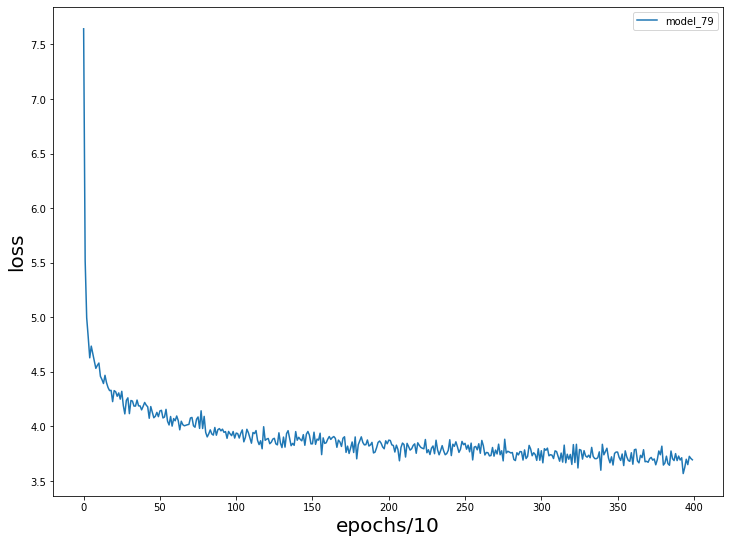

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure(figsize=(12,9))

plt.plot(all_losses1, label='models(79)')
plt.xlabel('epochs/10', fontsize=20)
plt.ylabel('loss', fontsize=20)

plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


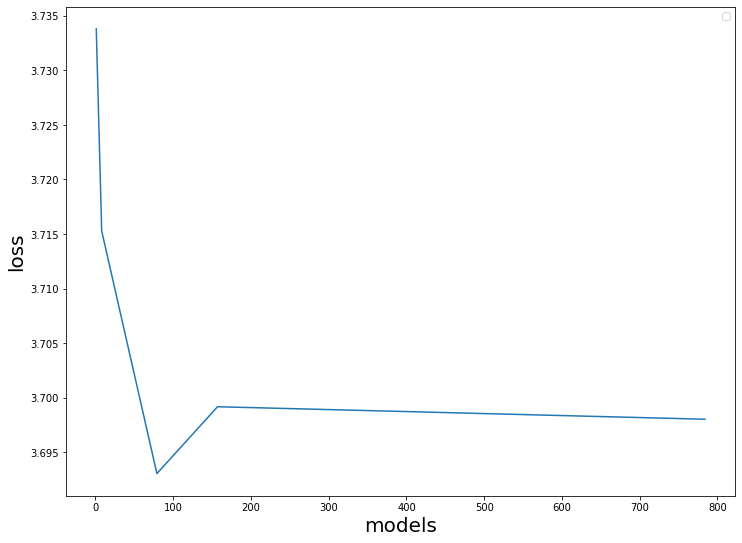

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure(figsize=(12,9))
x = [1, 8, 79, 157, 784]
y = [all_losses[399], all_losses2[399], all_losses1[399], all_losses4[399], all_losses3[399]]
plt.plot(x, y)
plt.xlabel('models', fontsize=20)
plt.ylabel('loss', fontsize=20)

plt.legend()

In [ ]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores


def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            print(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            print(output_words)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

searcher = GreedySearchDecoder(encoder, decoder)
evaluateInput(encoder, decoder, searcher, voc)



KeyboardInterrupt: Interrupted by user